In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

In [2]:
src = "/home/andres/repos/rat-mapping-paper/reports/L_CIRC/inference.pkl"

with open(src, "rb") as f:
    df, encoder_dict, model, posterior_samples, = pickle.load(f)


# prediction_df = model.make_prediction_dataset(df=df, min_intensity=0., max_intensity=500.)
# posterior_predictive = model.predict(
#     df=prediction_df, posterior_samples=posterior_samples
# )


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
src = os.path.join("/home/andres/repos/rat-mapping-paper/reports/L_CIRC/predictions.pkl")

with open(src, "rb") as f:
    x, orig_y, subjects, compound_positions, configurations, response, = pickle.load(f)

y = orig_y

In [4]:
y.shape

(8, 21, 3, 400, 6, 1000)

In [5]:
config = 2
muscle_ind = [0, 1, 2, 3, 4, 5]

y = y[:, :, config, ...]
y = y[..., muscle_ind, :]

y.shape

(8, 21, 400, 6, 1000)

In [6]:
y_max = ma.max(y, axis=(1, -1), keepdims=True) 

y_norm = ma.where(y, y / y_max, 0.)
y_norm.shape

p = ma.sum(y_norm, axis=-2, keepdims=True)
p = ma.where(y_norm, y_norm / p, 0.)
p.shape # (8, 21, 400, 6, 1000)

ma.any(p, axis=-2, keepdims=True).shape
plogp = ma.where(p, p * ma.log(p), 0)
plogp.shape # (8, 21, 3, 400, 6, 1000) 


entropy = ma.where(
    ma.any(p, axis=-2, keepdims=True),
    (
        1
        + (ma.sum(plogp, axis=-2, keepdims=True) / np.log(plogp.shape[-2]))
    ),
    0.
) # (8, 21, 3, 400, 6, 1000)
entropy = entropy[..., 0, :]
entropy.shape # (8, 21, 3, 400, 1000)


entropy_mean = ma.mean(entropy, axis=-2) # (8, 21, 3, 1000)
entropy_mean.shape

(8, 21, 1000)

In [24]:
a = posterior_samples

In [22]:
x.shape

(1000,)

In [19]:
area_list = []
for subject_ind, subject in enumerate(subjects):
    j = 0
    for cpos_ind, cpos in enumerate(compound_positions):
        if entropy_mean.mask[subject_ind, cpos_ind, 0]:
            continue
        sample_integrals = entropy[subject_ind, cpos_ind, :, :]
        sample_integrals_mean = sample_integrals.mean(axis=0)
        x = x / 
        area = np.trapz(sample_integrals_mean, x)
        area_list.append((subject, cpos, area))

filt_positions = list(set((a[1] for a in area_list)))

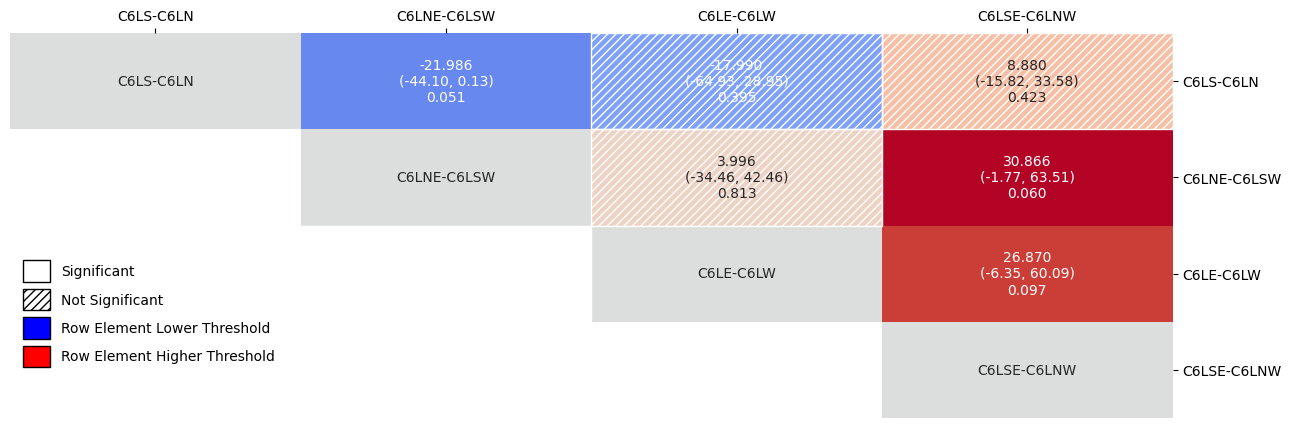

In [20]:
pvalues = []
means = []
lab = []
labels = []

for pos_ind_one, p_one in enumerate(filt_positions):    
    for pos_ind_two, p_two in enumerate(filt_positions):         
        if pos_ind_one == pos_ind_two:
            pvalues.append((0))
            lab.append(p_one)
            means.append(0)
            labels.append(p_one)
            continue
        group_one = np.array(list(a[2] for a in area_list if a[1] == p_one))
        group_two = np.array(list(a[2] for a in area_list if a[1] == p_two))
        ttest = stats.ttest_rel(group_one, group_two, alternative='two-sided')
        pvalues.append(ttest.pvalue)
        ci = ttest.confidence_interval(.95)
        # pvalues.append((p_one, p_two, f"{stats.ttest_rel(group_one, group_two, alternative='two-sided')[1]}"))
        t = group_one - group_two
        means.append(t.mean())
        lab.append(f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})\n{ttest.pvalue:.3f}")

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(4,4)

means = np.array(means)
means = means.reshape(4,4)

lab = np.array(lab)
lab = lab.reshape(4,4)
# unique_pvalues = set(tuple(sorted(t)) for t in pvalues)

mask = np.tril(np.ones_like(means), k=-1)
# mask = np.tril(np.ones_like(mask), k=-1)
plt.figure(figsize=(15, 5))
ax =sns.heatmap(means, xticklabels= labels, annot = lab, yticklabels= labels, mask = mask, fmt = "", cbar = False,center = 0, cmap = "coolwarm")

hatch_mask = pvalues > 0.1
handles = []

for i in range (pvalues.shape[0]):
  for j in range(pvalues.shape[1]):
      if hatch_mask[i, j]:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
          handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
plt.show()
